# Compare the projections of global thermal expansion (GTE) and ocean dynamic sea level (ODSL) for different selections of CMIP6 models

In [3]:
root = '/Users/dewilebars/Projects/'
slproj_dir = f'{root}/Project_ProbSLR/SLProj/'
dataproj_dir = f'{root}/Project_ProbSLR/Data_Proj/'

import sys
sys.path.append(f'{slproj_dir}code')

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import func_misc as misc

from scipy.stats import linregress

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [4]:
zos_model_selection = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CNRM-CM6-1', 
                       'CNRM-ESM2-1', 'EC-Earth3', 'GISS-E2-1-G', 
                       'INM-CM4-8', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 
                       'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

print('Number of models:')
len(zos_model_selection)

Number of models:


13

## GTE

In [5]:
# Read global steric
cmip6_zostoga = []
list_scen = ['ssp126', 'ssp245', 'ssp585']

for scen in list_scen:
    ds = misc.read_zostoga_ds(dataproj_dir, scen)
    cmip6_zostoga.append(ds['zostoga_corrected']*100)


In [6]:
for scen in list_scen:
    intersection = list(set(cmip6_zostoga[1].model.data) & set(zos_model_selection) )

    print(f'Models with zos and zostoga available for {scen}:')
    print(len(intersection))

Models with zos and zostoga available for ssp126:
9
Models with zos and zostoga available for ssp245:
9
Models with zos and zostoga available for ssp585:
9


In [11]:
intersection

['NorESM2-LM',
 'EC-Earth3',
 'CNRM-ESM2-1',
 'UKESM1-0-LL',
 'INM-CM4-8',
 'CNRM-CM6-1',
 'ACCESS-ESM1-5',
 'NorESM2-MM',
 'MPI-ESM1-2-LR']

In [7]:
cmip6_zostoga_sel = [] 

for i in range(3):
    cmip6_zostoga_sel.append(cmip6_zostoga[i].sel(model=intersection))



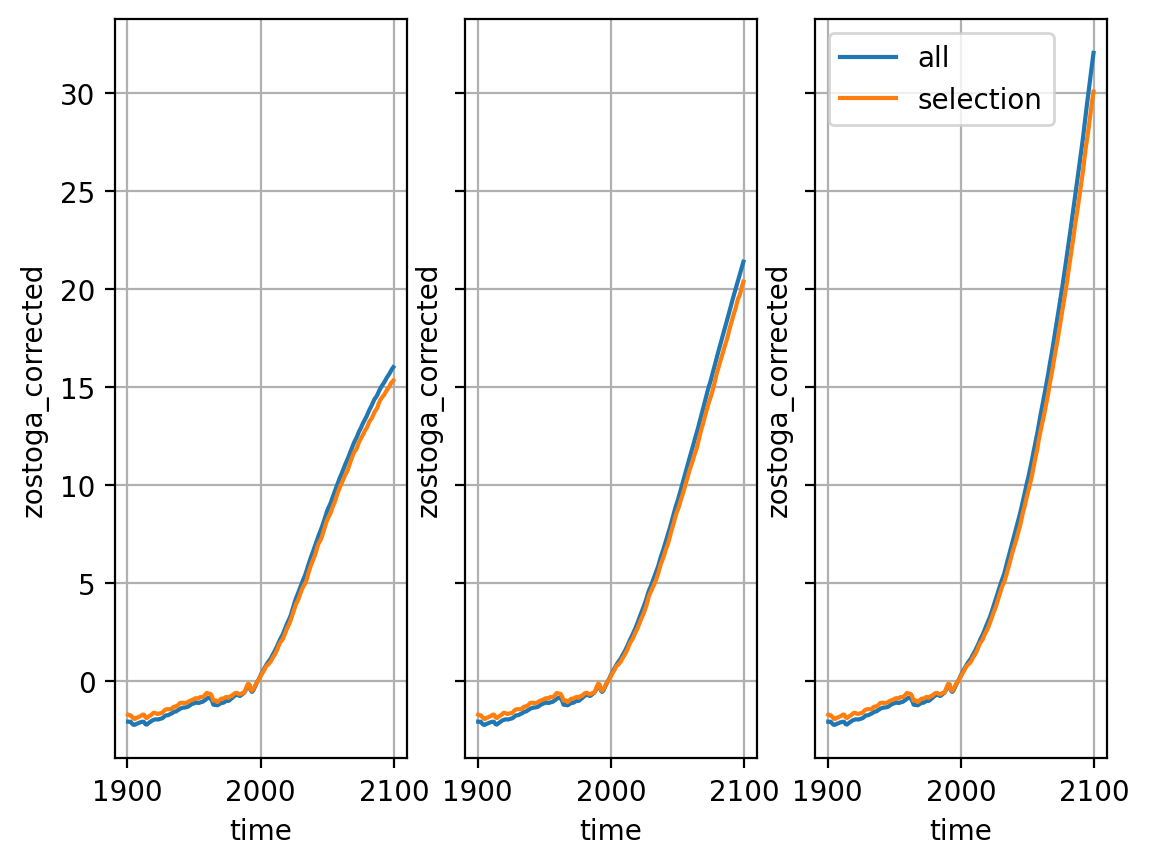

In [8]:
fig, axes = plt.subplots(ncols=3, sharey=True)

for i in range(3):
    cmip6_zostoga[i].mean(dim='model').plot(ax=axes[i], label='all')
    cmip6_zostoga_sel[i].mean(dim='model').plot(ax=axes[i], label='selection')
    
    axes[i].grid()

plt.legend()

In [9]:
# Compute linear trend difference

per = [1995, 2022]

print(f'Linear regression for period {per[0]}-{per[1]} [mm/yr]:')

for i in range(3):
    print(f'### {list_scen[i]} ###')
    all_per = cmip6_zostoga[i].sel(time=slice(per[0],per[1])).mean(dim='model')
    all_lin = linregress(all_per.time, all_per)
    
    sel_per = cmip6_zostoga_sel[i].sel(time=slice(per[0],per[1])).mean(dim='model')
    sel_lin = linregress(sel_per.time, sel_per)

    # Convert from cm/yr to mm/yr and print
    print(f'All models: {all_lin.slope*10}, selection: {sel_lin.slope*10} ')

Linear regression for period 1995-2022 [mm/yr]:
### ssp126 ###
All models: 1.3056345600613493, selection: 1.1946258633156575 
### ssp245 ###
All models: 1.3130969537641277, selection: 1.198313527979946 
### ssp585 ###
All models: 1.31642172553768, selection: 1.1910363078178274 


In [10]:
# Compare values with AR6

print('GTE difference between 2100 and 1995-2015')
print('')

for i in range(3):
    print(f'### {list_scen[i]} ###')
    
    diff_all = (cmip6_zostoga[i].sel(time=2099.5) - 
                cmip6_zostoga[i].sel(time=slice(1995,2016)).mean(dim='time'))
    
    diff_sel = (cmip6_zostoga_sel[i].sel(time=2099.5) - 
                cmip6_zostoga_sel[i].sel(time=slice(1995,2016)).mean(dim='time'))
    
    all_mean = round(diff_all.mean().values.item(), 2)
    sel_mean = round(diff_sel.mean().values.item(), 2)
    
    print(f'All models: {all_mean}, selection: {sel_mean} ')
    
    all_med = round(diff_all.quantile(0.5).values.item(), 2)
    all_17pc = round(diff_all.quantile(0.17).values.item(), 2)
    all_83pc = round(diff_all.quantile(0.83).values.item(), 2)

    sel_med = round(diff_sel.quantile(0.5).values.item(), 2)
    sel_17pc = round(diff_sel.quantile(0.17).values.item(), 2)
    sel_83pc = round(diff_sel.quantile(0.83).values.item(), 2)
    
    print(f'All models: {all_med} [{all_17pc} - {all_83pc}],' 
          f' selection: {sel_med} [{sel_17pc} - {sel_83pc}]')

GTE difference between 2100 and 1995-2015

### ssp126 ###
All models: 15.06, selection: 14.49 
All models: 14.97 [13.89 - 17.77], selection: 14.76 [13.9 - 16.65]
### ssp245 ###
All models: 20.45, selection: 19.53 
All models: 20.01 [18.6 - 23.9], selection: 19.42 [18.52 - 22.39]
### ssp585 ###
All models: 31.11, selection: 29.23 
All models: 30.35 [27.65 - 36.34], selection: 28.39 [27.64 - 32.37]


In [12]:
# Test ODSL func


nb_y2 = ye - ys +1

# Read global steric
full_st_da = misc.read_zostoga_ds(data_dir, SCE)

# Convert from m to cm
MAT_G = full_st_da['zostoga_corrected'].sel(time=slice(ref_steric[0],ye))*100

if LOC:
    lat_N, lat_S, lon_W, lon_E = LOC

    zos_ds = misc.read_zos_ds(data_dir, SCE)

    full_sd_da = zos_ds['CorrectedReggrided_zos'].sel(time=slice(ref_steric[0],ye), 
                            lat=slice(lat_S,lat_N), 
                            lon=slice(lon_W,lon_E))

    # There are more models available for zos than for zostoga
    # Here we select the intersection
    model_list = list(set(full_sd_da.model.values) & set(MAT_G.model.values))

    if ODSL_LIST:
        # Select a list of models chosen in the namelist
        print("### Sub-selecting models")
        print("Before selection:")
        print(model_list)
        model_list = list(set(model_list) & set(ODSL_LIST))
        print("After selection")
        print(model_list)

    MAT_A = full_sd_da.sel(model=model_list).mean(dim=['lat', 'lon'])

    if BiasCorr:
        # Use a bias correction based on the comparison of model and 
        # observations between 1979 and 2018
        MAT_A = MAT_A*BiasCorr

    MAT = MAT_A + MAT_G

In [40]:
# Read global steric
data_dir = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
SCE = 'ssp245'

ODSL_LIST = ['ACCESS-ESM1-5', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 
             'EC-Earth3', 'GISS-E2-1-G', 'INM-CM4-8', 'MIROC-ES2L', 
             'MPI-ESM1-2-LR', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']

full_st_da = misc.read_zostoga_ds(data_dir, SCE)

# Convert from m to cm
MAT_G = full_st_da['zostoga_corrected'].sel(time=slice(1995,2100))*100

lat_N, lat_S, lon_W, lon_E = [60, 51, -3.5, 7.5]
zos_ds = misc.read_zos_ds(data_dir, SCE)

full_sd_da = zos_ds['CorrectedReggrided_zos'].sel(time=slice(1995,2100), 
                        lat=slice(lat_S,lat_N), 
                        lon=slice(lon_W,lon_E))

# There are more models available for zos than for zostoga
# Here we select the intersection
model_list = list(set(full_sd_da.model.values) & set(MAT_G.model.values))

if ODSL_LIST:
    # Select a list of models chosen in the namelist
    print("### Sub-selecting models")
    print("Before selection:")
    print(model_list)
    model_list = list(set(model_list) & set(ODSL_LIST))
    print("After selection")
    print(model_list)
    
MAT_A = full_sd_da.sel(model=model_list).mean(dim=['lat', 'lon'])

MAT = MAT_A + MAT_G

### Sub-selecting models
Before selection:
['MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'NorESM2-MM', 'CNRM-CM6-1', 'NorESM2-LM', 'CNRM-ESM2-1', 'INM-CM4-8', 'MIROC6', 'HadGEM3-GC31-LL', 'INM-CM5-0', 'ACCESS-CM2', 'EC-Earth3', 'UKESM1-0-LL', 'CanESM5-CanOE', 'CanESM5', 'CMCC-CM2-SR5', 'MRI-ESM2-0', 'EC-Earth3-Veg']
After selection
['NorESM2-LM', 'EC-Earth3', 'CNRM-ESM2-1', 'UKESM1-0-LL', 'INM-CM4-8', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'NorESM2-MM', 'MPI-ESM1-2-LR']


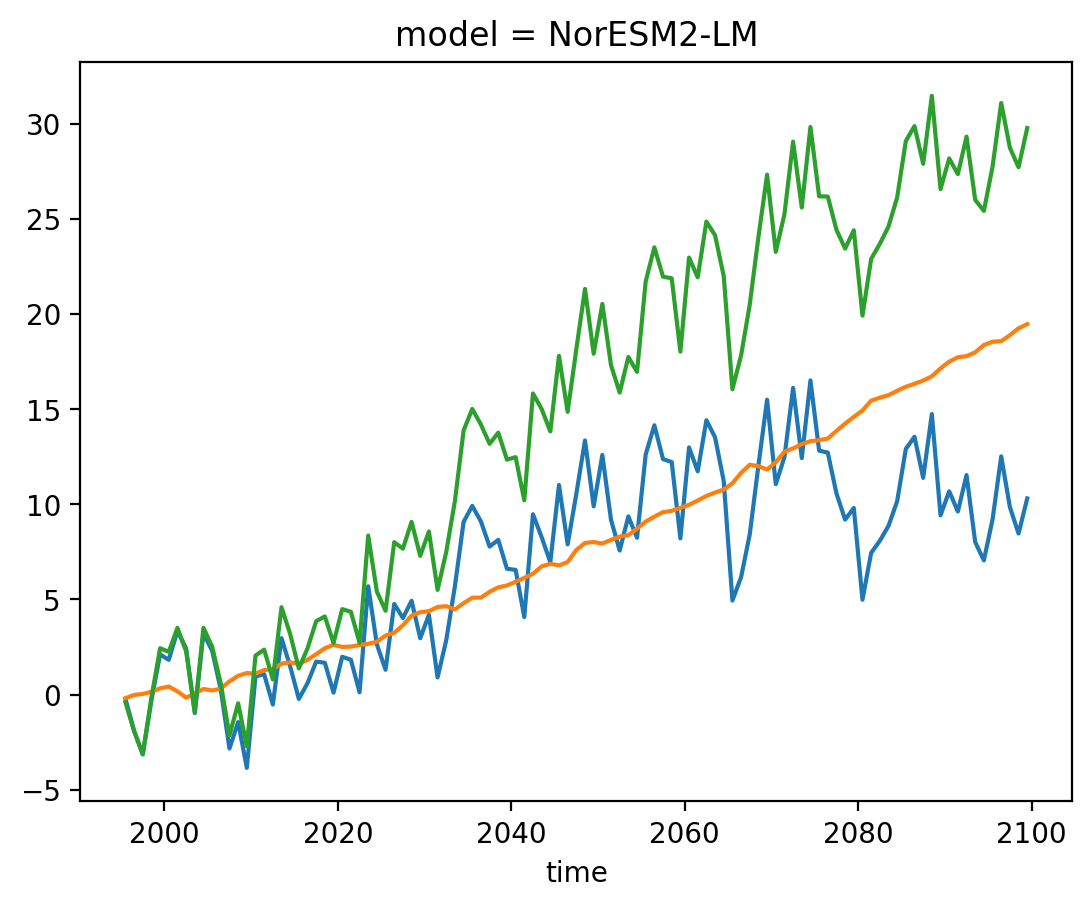

In [41]:
MAT_A.sel(model='NorESM2-LM').plot()
MAT_G.sel(model='NorESM2-LM').plot()
MAT.sel(model='NorESM2-LM').plot()

In [55]:
ys = 1995
ye = 2100
deg = 3

new_time = xr.DataArray( np.arange(ys,ye+1)+0.5, dims='time', 
                coords=[np.arange(ys,ye+1)+0.5], name='time' )
fit_coeff = MAT.polyfit('time', deg)
MATf = xr.polyval(coord=new_time, coeffs=fit_coeff.polyfit_coefficients)       
fit_coeff = MAT_G.polyfit('time', deg)
MATf_G = xr.polyval(coord=new_time, coeffs=fit_coeff.polyfit_coefficients)
MATf_A = MATf - MATf_G

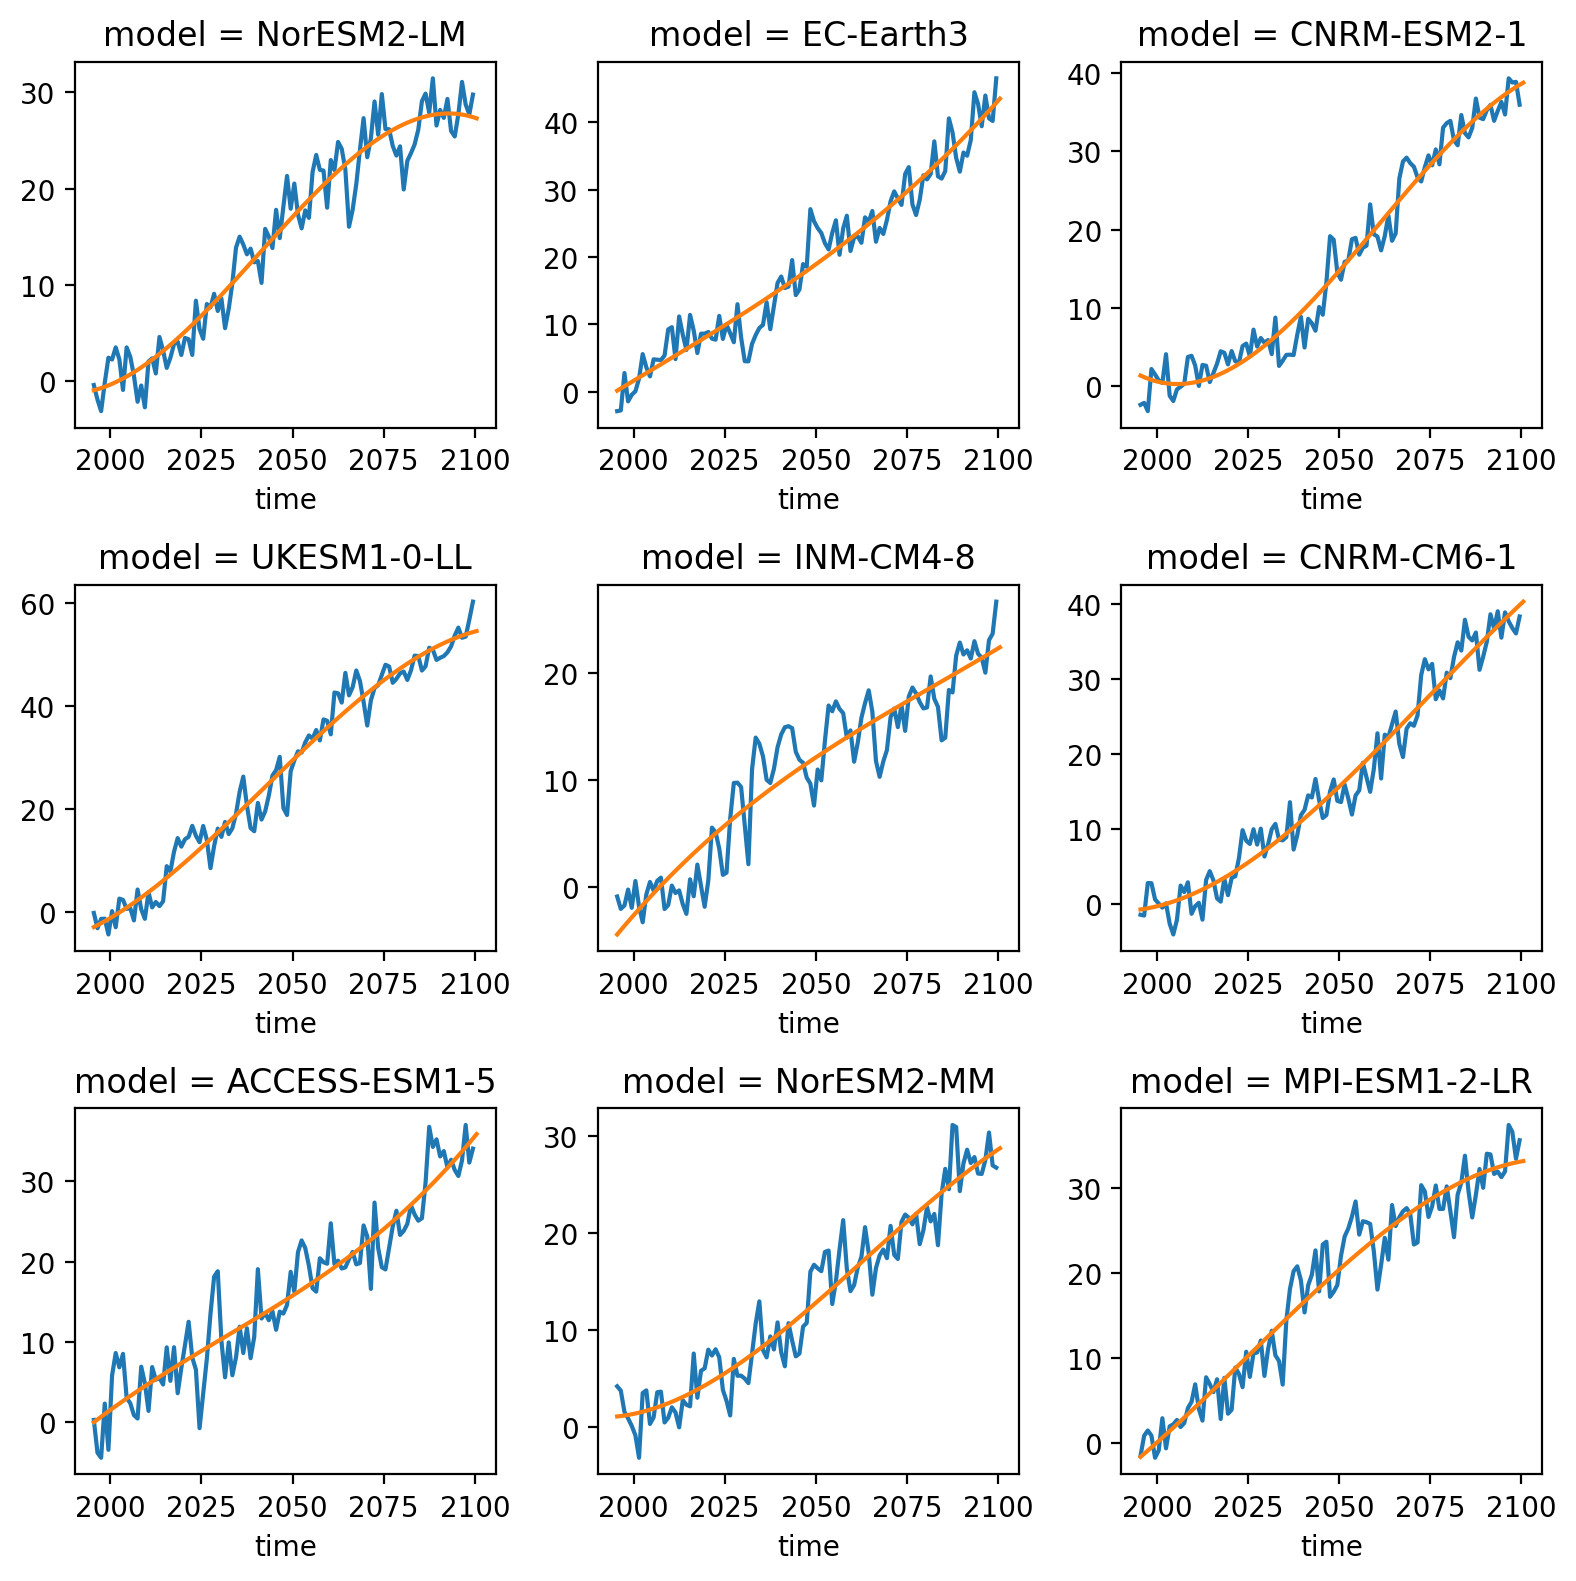

In [56]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=[8,8])

for i in range(9):
    MAT.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    MATf.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    
plt.tight_layout()

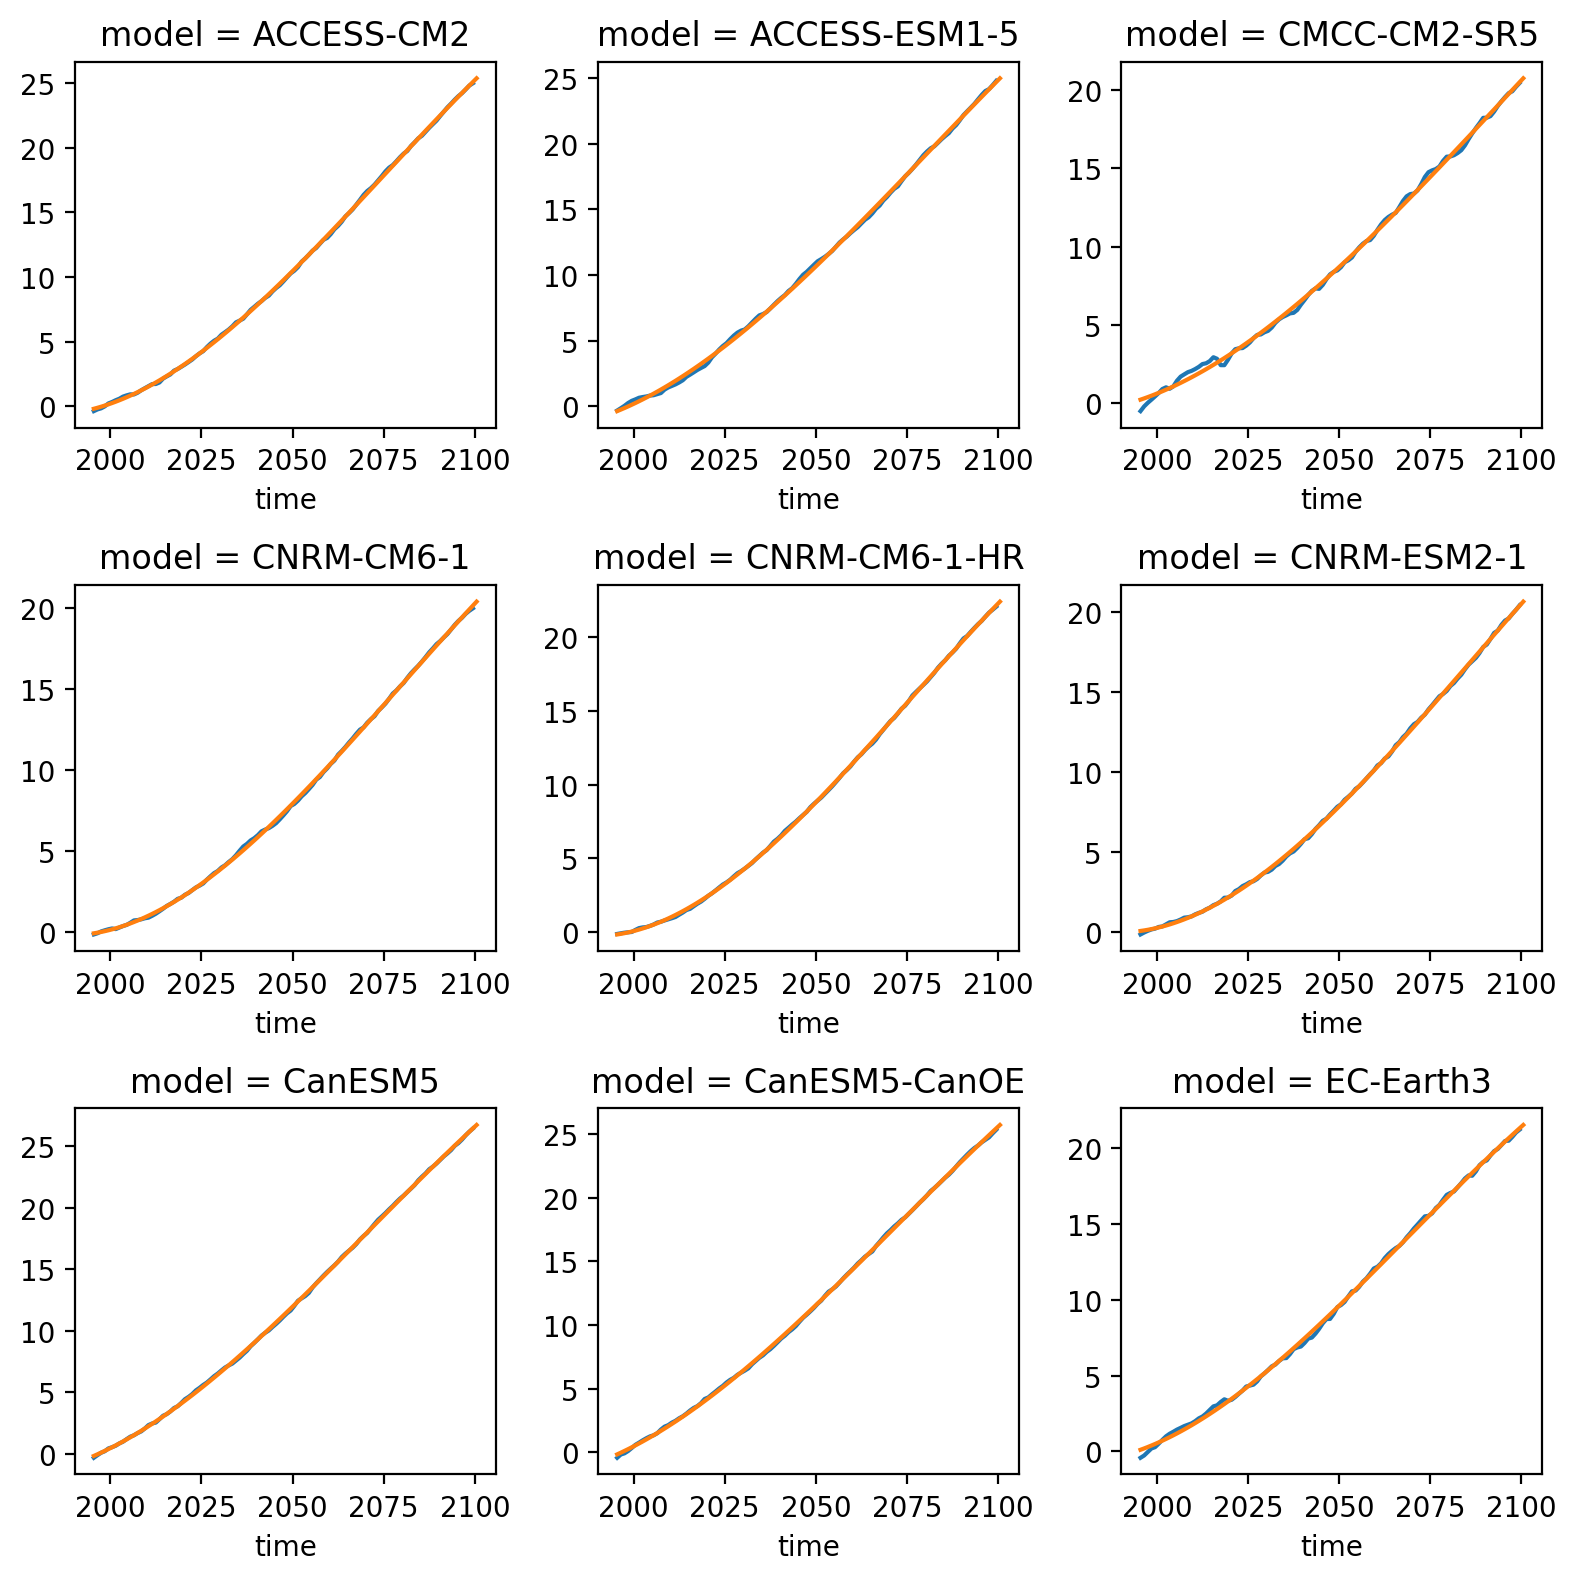

In [57]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=[8,8])

for i in range(9):
    MAT_G.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    MATf_G.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    
plt.tight_layout()

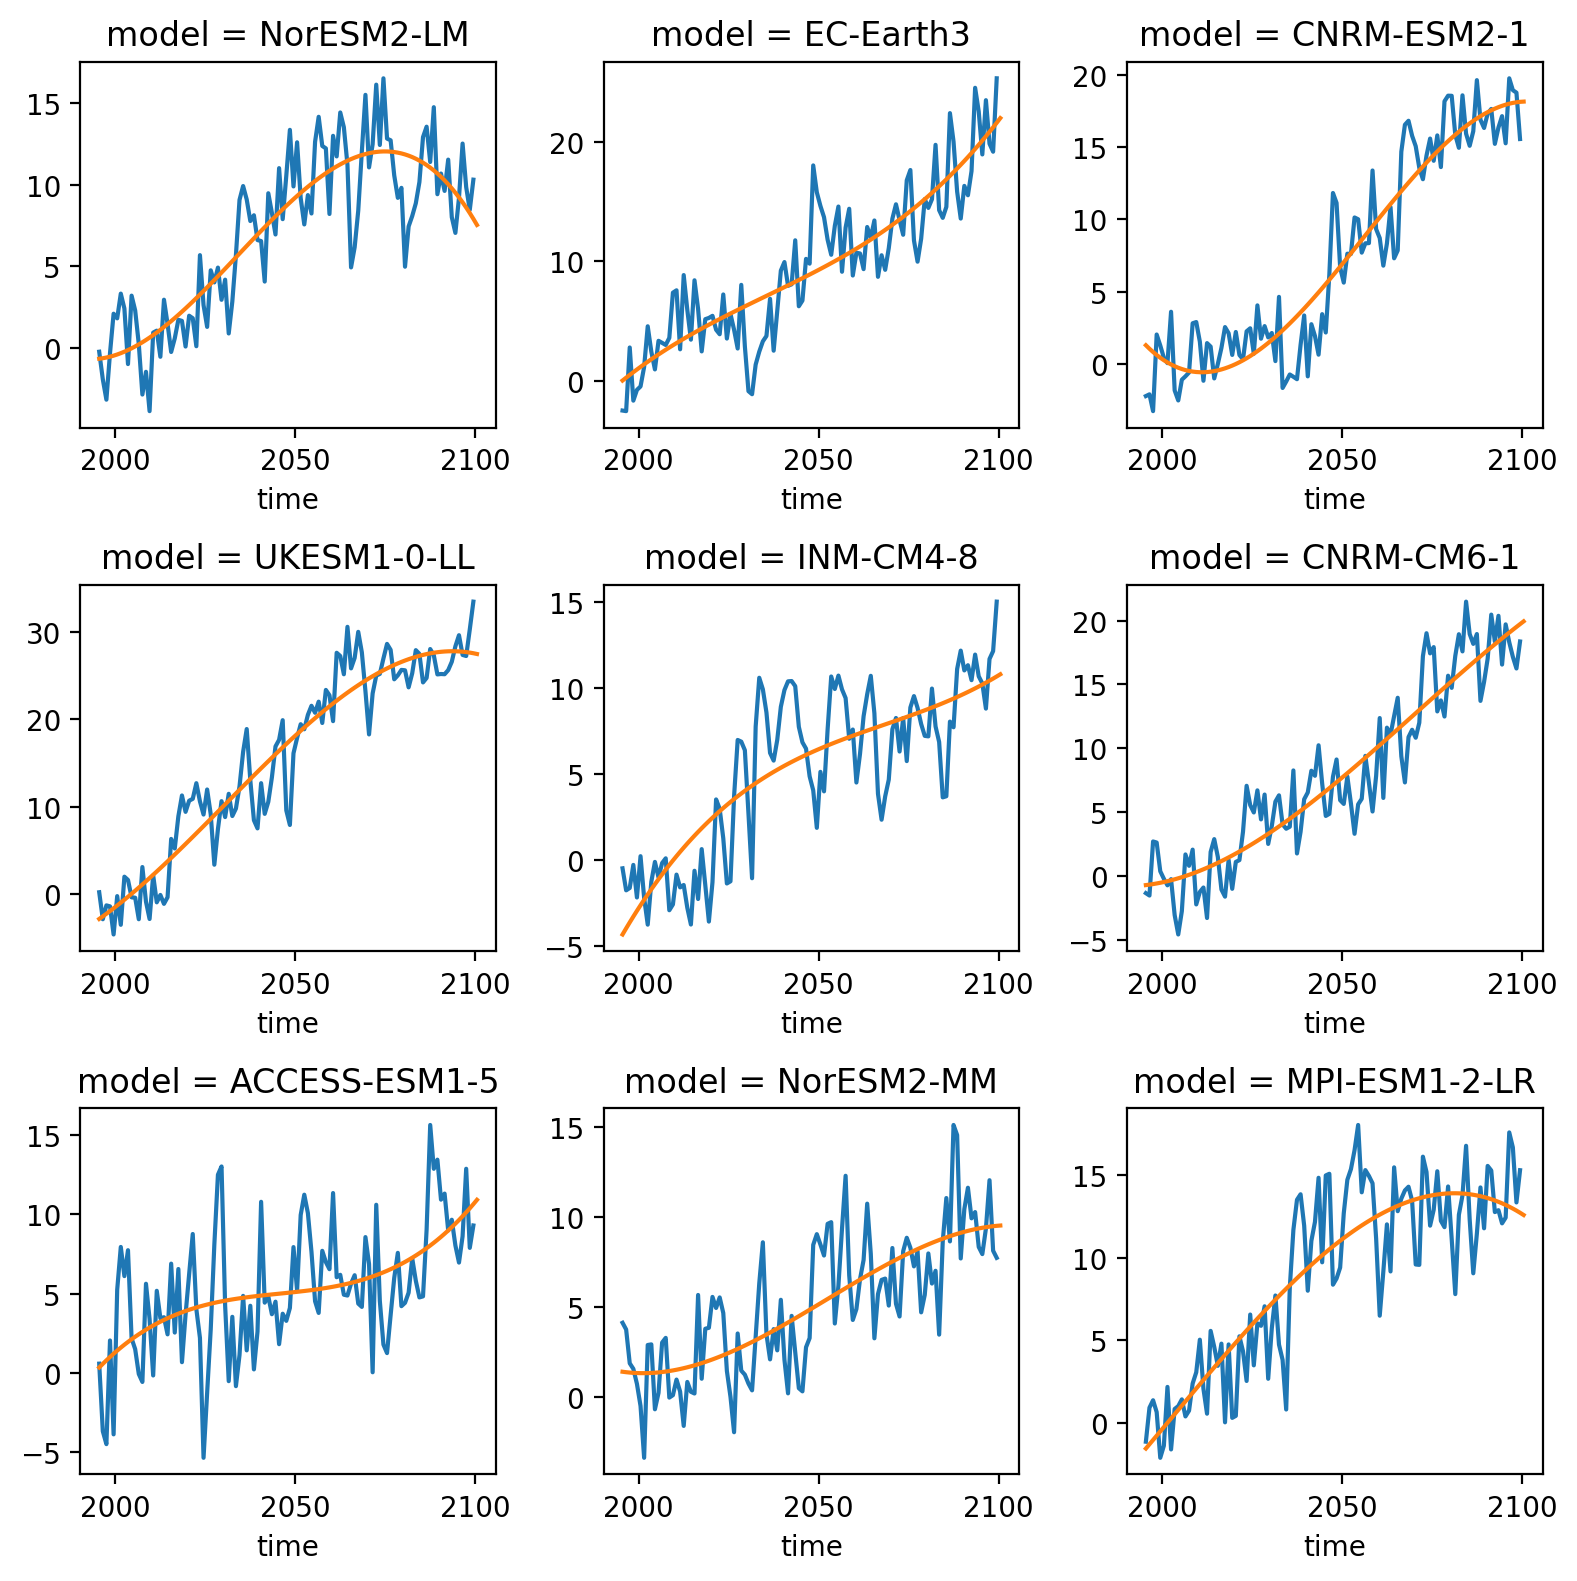

In [58]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=[8,8])

for i in range(9):
    MAT_A.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    MATf_A.isel(model=i).plot.line(ax=axes.flat[i], x='time')
    
plt.tight_layout()

In [68]:
mam = MATf_A.sel(time = slice(1995.5,2021.5)).mean(dim='model')

linreg = linregress(mam.time, mam)

linreg.slope*10

1.60637837676088

In [67]:
mam = MAT_A.sel(time = slice(1995.5,2021.5)).mean(dim='model')

linreg = linregress(mam.time, mam)

linreg.slope*10

1.5271624935448123

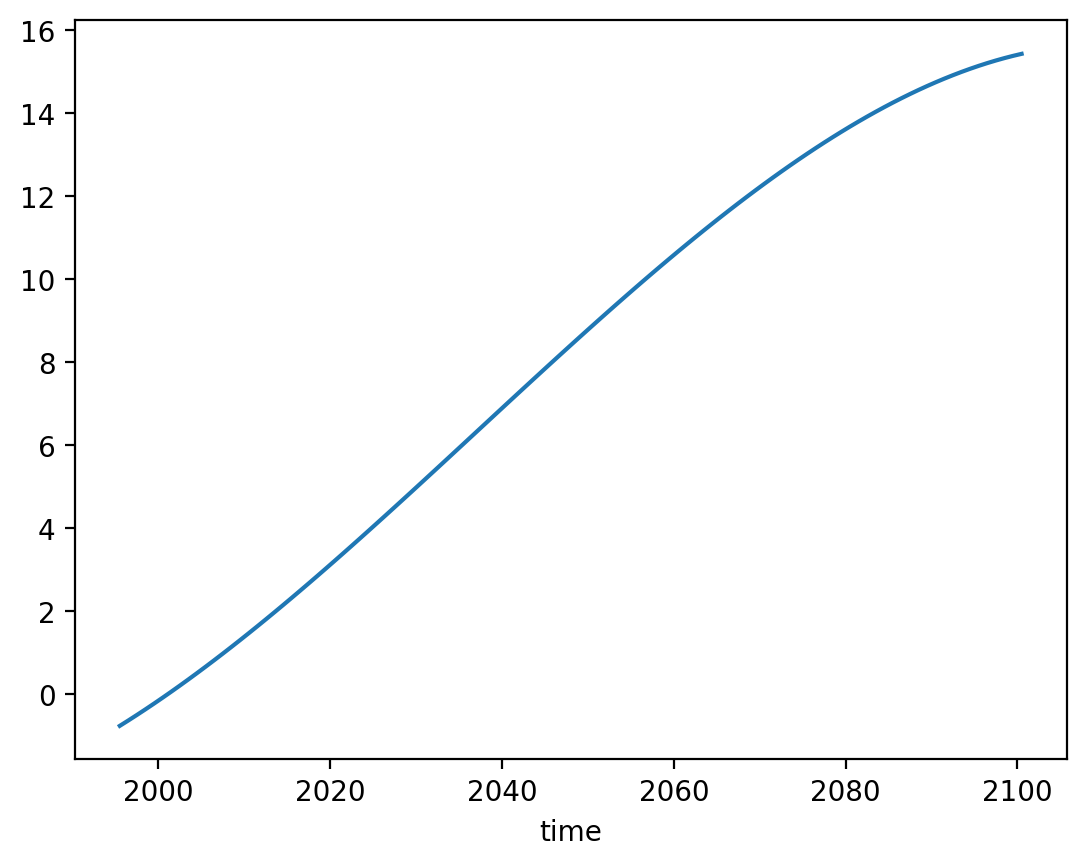

In [60]:
MATf_A.mean(dim='model').plot()

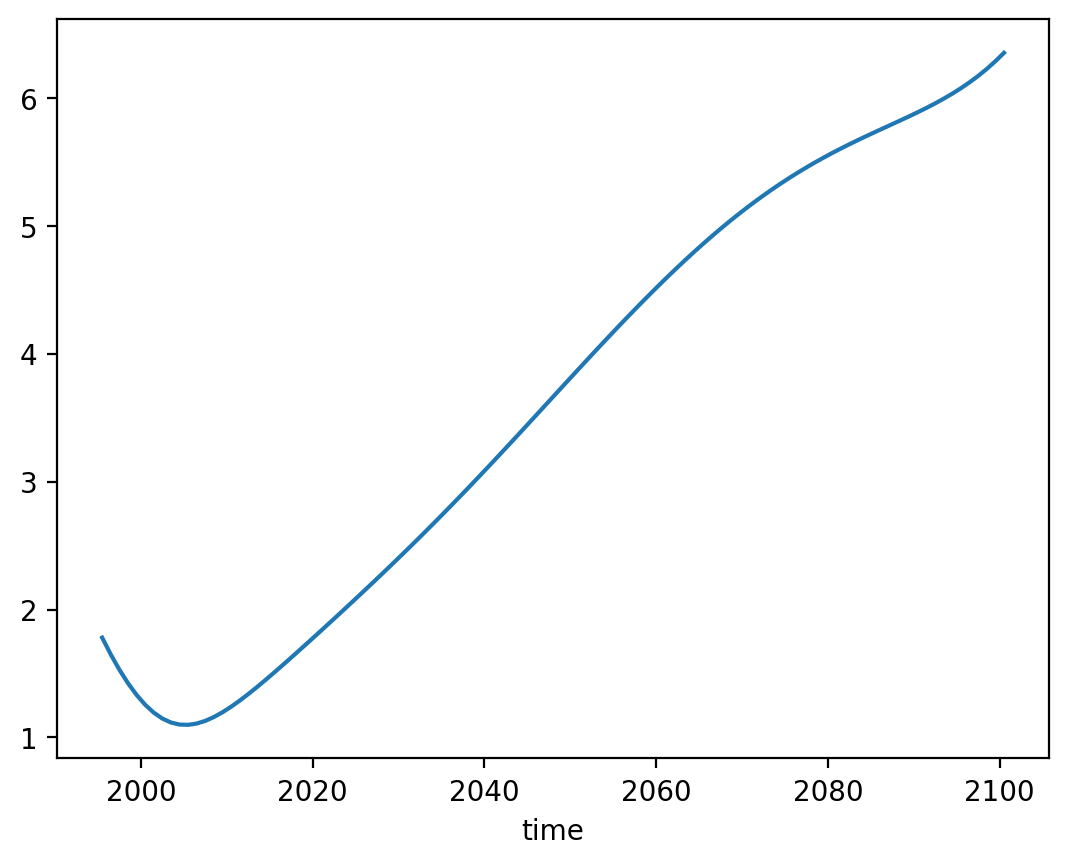

In [62]:
MATf_A.std(dim='model').plot()

In [74]:
LOC = False

if not(LOC):
    print('yes')
    
elif len(LOC) == 4:
    
elif len(LOC) >  4

yes
